In [138]:
from pyrqa.time_series import TimeSeries
from pyrqa.settings import Settings
from pyrqa.analysis_type import Classic, Cross
from pyrqa.neighbourhood import FixedRadius
from pyrqa.metric import EuclideanMetric
from pyrqa.computation import RQAComputation
from pyrqa.image_generator import ImageGenerator

import pandas as pd
import glob
import re
import numpy as np
import seaborn as sns

sns.set()

from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt


In [ ]:
# This is example code
data_points = [0.1, 0.5, 1.3, 0.7, 0.8, 1.4, 1.6, 1.2, 0.4, 1.1, 0.8, 0.2, 1.3]
time_series = TimeSeries(data_points,
                         embedding_dimension=2,
                         time_delay=2)
settings = Settings(time_series,
                    analysis_type=Classic,
                    neighbourhood=FixedRadius(0.65),
                    similarity_measure=EuclideanMetric,
                    theiler_corrector=1)
computation = RQAComputation.create(settings,
                                    verbose=True)
result = computation.run()
result.min_diagonal_line_length = 2
result.min_vertical_line_length = 2
result.min_white_vertical_line_length = 2
print(result)

In [139]:
log_path = 'data/hand_eye_combined_logs'
out_plots_path = 'out/plots'

In [142]:
dfs = []

for f in glob.glob(log_path + "/*_Normalized.txt"):
  d = pd.read_csv(f, sep="\s+")
  id = re.findall(".*Subject_(\d+)_.*", f)[0]
  d["id"] = id
  dfs.append(d)

df_all_students = pd.concat(dfs, ignore_index=True)

In [277]:
for group_id, group_df in df_all_students.groupby(['id']):
  print(max(group_df['TIME[s]']) / 60)

3.3133333333333335
4.3966666666666665
4.263333333333334
3.5133333333333336
5.113333333333333
5.680000000000001
4.263333333333334
5.48
8.08
9.396666666666667
3.3800000000000003
3.2633333333333336
3.3800000000000003
5.913333333333333


In [141]:
def cross_rqa(x, y, id,plot=True,verbose=True):
  data_points_x = x # [0.9, 0.1, 0.2, 0.3, 0.5, 1.7, 0.4, 0.8, 1.5]
  time_series_x = TimeSeries(data_points_x,
                            embedding_dimension=2,
                            time_delay=1)
  data_points_y = y # [0.3, 1.3, 0.6, 0.2, 1.1, 1.9, 1.3, 0.4, 0.7, 0.9, 1.6]
  time_series_y = TimeSeries(data_points_y,
                            embedding_dimension=2,
                            time_delay=2)
  time_series = (time_series_x,
                time_series_y)
  settings = Settings(time_series,
                      analysis_type=Cross,
                      neighbourhood=FixedRadius(0.73),
                      similarity_measure=EuclideanMetric,
                      theiler_corrector=0)
  computation = RQAComputation.create(settings)
  result = computation.run()
  result.min_diagonal_line_length = 2
  result.min_vertical_line_length = 2
  result.min_white_vertical_line_length = 2

  if(plot):
    ImageGenerator.save_recurrence_plot(result.recurrence_matrix_reverse,
                                        f'%s/%s_cross_recurrence_plot.png' % (out_plots_path, id))

  if(verbose): print(result)

  return result

In [289]:
# build up a new dataframe of rqa metrics for different time windows
# each row will contain: (student id | time window | ...rqa metrics)
window = 600 # window of 10 ==> 1 second
rqa_rows = []
for group_id, group_df in df_all_students.groupby(['id']):

    # forward/back fill NaN values to previous/next position
    group_df['LeftY'] = group_df['LeftY'].ffill()
    group_df['LeftY'] = group_df['LeftY'].bfill()
    group_df['RightY'] = group_df['RightY'].ffill()
    group_df['RightY'] = group_df['RightY'].bfill()

    start = 0

    for i in range(int(len(group_df) / window)):
        x = group_df.iloc[start:start+window]['LeftY']
        y = group_df.iloc[start:start+window]['RightY']

        time_range = f"%s_%s" % (group_df.iloc[start]['TIME[s]'], group_df.iloc[start+window]['TIME[s]'])

        result = cross_rqa(x=x,y=y, id=group_id,plot=False,verbose=False)

        row = [
            group_id, 
            time_range, 
            result.recurrence_rate,
            result.determinism,
            result.average_diagonal_line,
            result.longest_diagonal_line,
            result.divergence,
            result.entropy_diagonal_lines,
            result.laminarity,
            result.trapping_time,
            result.longest_vertical_line,
            result.entropy_vertical_lines,
            result.average_white_vertical_line,
            result.longest_white_vertical_line,
            result.entropy_white_vertical_lines,
            result.ratio_determinism_recurrence_rate,
            result.ratio_laminarity_determinism
            ]

        rqa_rows.append(row)
        start = start + window

rqa_df = pd.DataFrame(rqa_rows,
    columns=[
        'id', 
        'time_window', 
        "recurrence_rate",
        "determinism",
        "average_diagonal_line",
        "longest_diagonal_line",
        "divergence",
        "entropy_diagonal_lines",
        "laminarity",
        "trapping_time",
        "longest_vertical_line",
        "entropy_vertical_lines",
        "average_white_vertical_line",
        "longest_white_vertical_line",
        "entropy_white_vertical_lines",
        "ratio_determinism_recurrence_rate",
        "ratio_laminarity_determinism"
        ])

In [290]:
rqa_df[['recurrence_rate','determinism','average_diagonal_line','entropy_diagonal_lines','trapping_time']].isnull()


,recurrence_rate,determinism,average_diagonal_line,entropy_diagonal_lines,trapping_time
0,False,False,True,False,False
1,False,False,True,False,True
2,False,False,False,False,False
3,False,False,False,False,False
4,False,False,False,False,False
...,...,...,...,...,...
59,False,False,False,False,False
60,False,True,True,False,True
61,False,False,False,False,False
62,False,True,True,False,True


In [291]:

# drop NaN values
# this drops almost all rows ==> why is determinism NaN so often?

# print(f"length of rqa df with nans: %s" % len(rqa_df))

# rqa_df.dropna(subset=['recurrence_rate','determinism','average_diagonal_line','entropy_diagonal_lines','trapping_time'], inplace=True)

# print(f"length of rqa df without nans: %s" % len(rqa_df))

# print(rqa_df['recurrence_rate'].value_counts())
# print(rqa_df['determinism'].value_counts())
# print(rqa_df['average_diagonal_line'].value_counts())
# print(rqa_df['entropy_diagonal_lines'].value_counts())
# print(rqa_df['trapping_time'].value_counts())


<AxesSubplot:xlabel='recurrence_rate', ylabel='Count'>

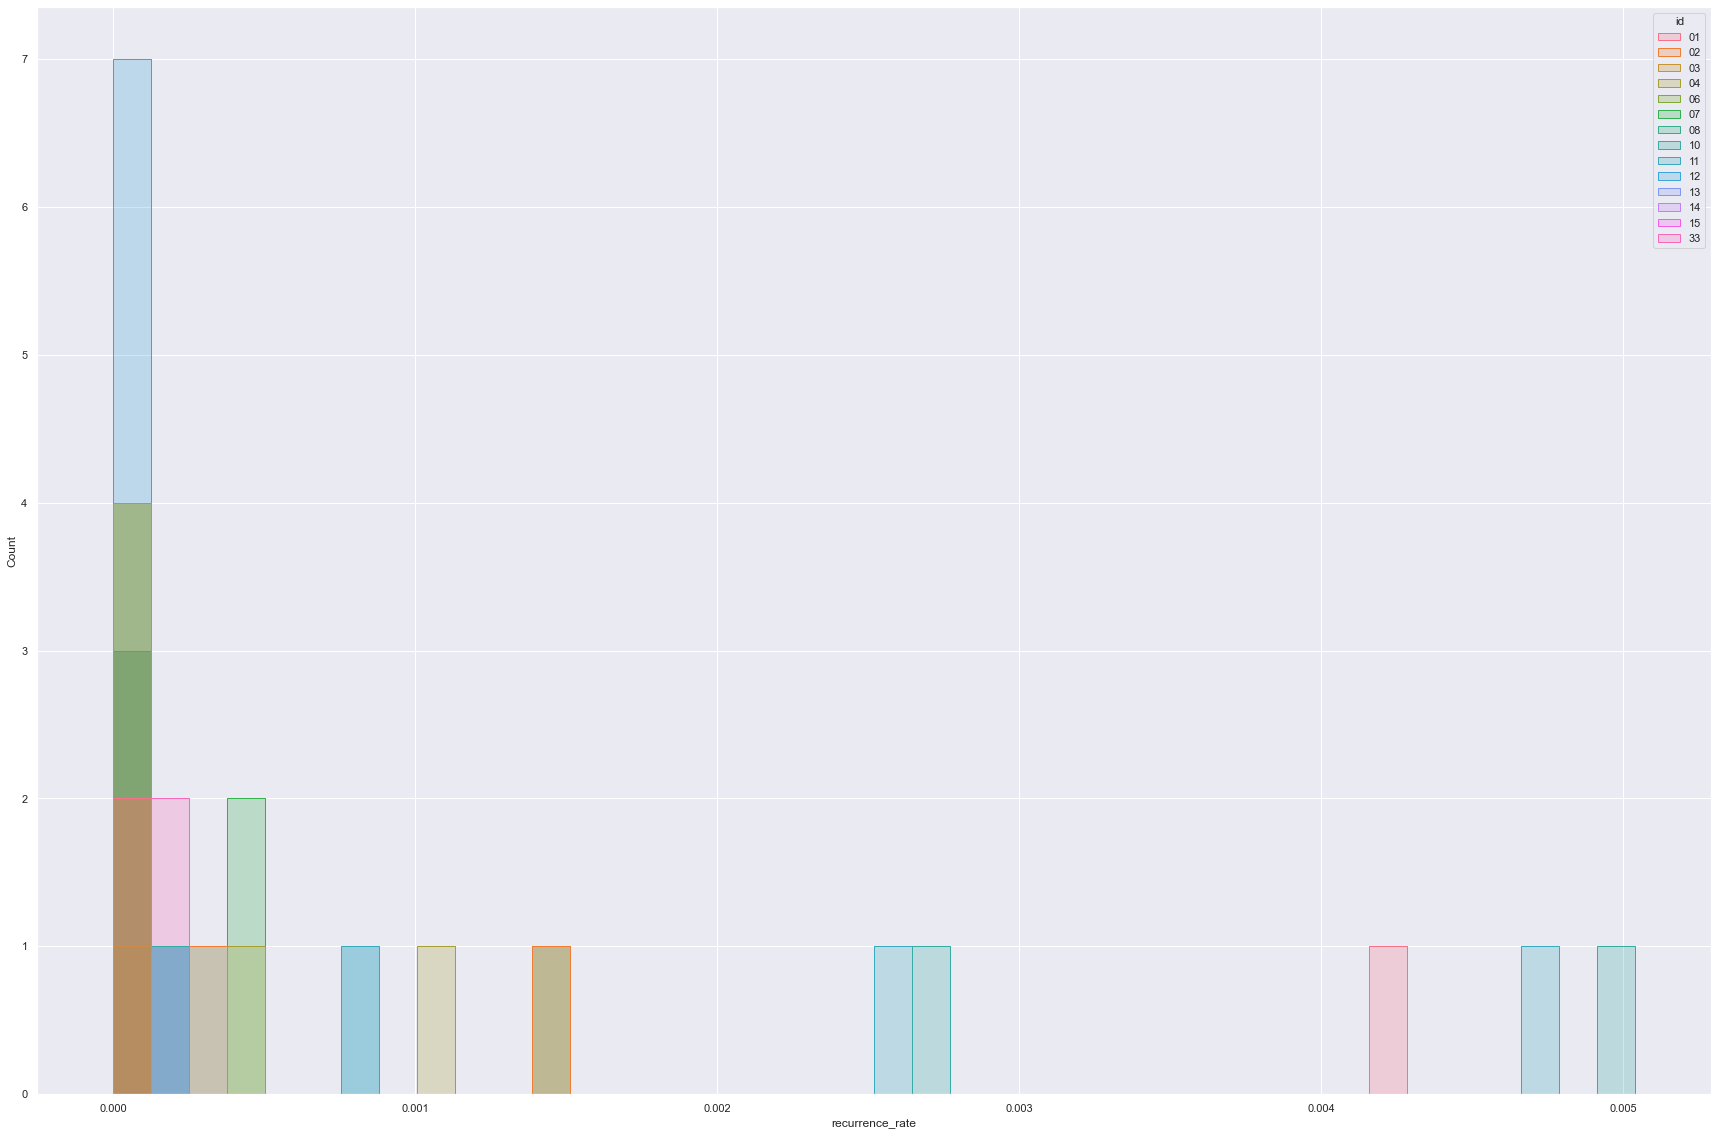

In [292]:
sns.set(rc={"figure.figsize":(30, 20)})
sns.histplot(data=rqa_df, x="recurrence_rate", hue='id', element="step")

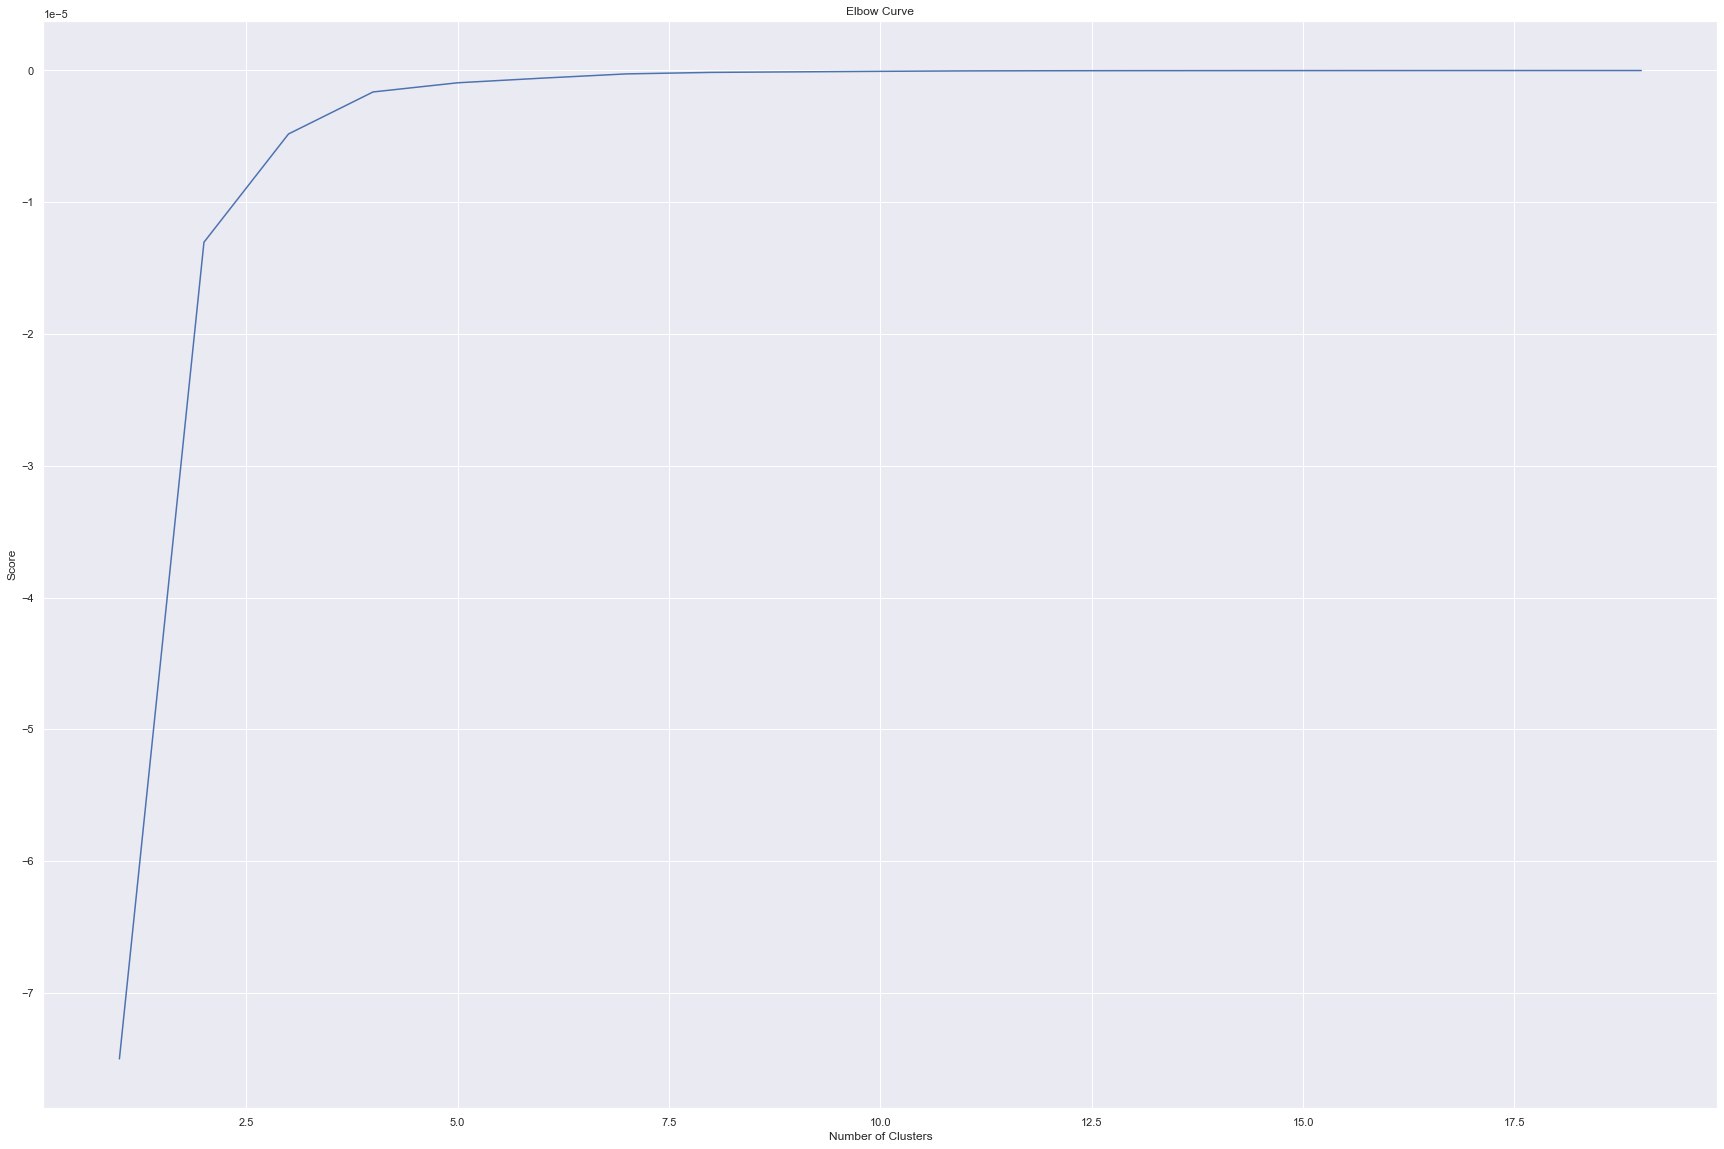

In [293]:
km_columns = ['recurrence_rate'] #['recurrence_rate','determinism','average_diagonal_line','entropy_diagonal_lines','trapping_time']

# find the best k val based on elbow method
km_df = pd.DataFrame(rqa_df[km_columns])

ks = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in ks]
score = [kmeans[i].fit(km_df).score(km_df) for i in range(len(kmeans))]

plt.plot(ks,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [294]:
# cluster data and visualize via TSNE dim reduction
# this produces df_viz.tsv, which is used in d3-scatterplot as an external tool
n_clusters = 4

km = KMeans(n_clusters=n_clusters)
y_km = km.fit_predict(km_df)
df_embed=TSNE(n_components=2, perplexity=50, method='barnes_hut', init='random', learning_rate='auto').fit_transform(km_df)

df_viz = pd.DataFrame(df_embed[:,:2],columns=["x","y"])

for c in km_columns:
  df_viz[c] = rqa_df[c]

# df_viz['Recurrence rate'] = rqa_df['recurrence_rate']
# df_viz['Determinism'] = rqa_df['determinism']
# df_viz['Mean line length'] = rqa_df['average_diagonal_line']
# df_viz['Normalized entropy'] = rqa_df['entropy_diagonal_lines']
# df_viz['Trapping time'] = rqa_df['trapping_time']
df_viz['Time window'] = rqa_df['time_window']
df_viz['Student ID'] = rqa_df['id']
df_viz['Clusters'] = km.labels_
df_viz.to_csv(f'../../mled-scatterplot/d3-scatterplot/df_viz_window=%is_k=%i.tsv' % (window/10, n_clusters), sep='\t', index=False)

print(f'written to d3-scatterplot/df_viz_window=%is_k=%i.tsv' % (window/10, n_clusters))

written to d3-scatterplot/df_viz_window=60s_k=4.tsv


For n_clusters = 3 The average silhouette_score is : 0.9775724547687484
For n_clusters = 4 The average silhouette_score is : 0.9742255228748923
For n_clusters = 5 The average silhouette_score is : 0.9606838808522733
For n_clusters = 6 The average silhouette_score is : 0.9583160449814752
For n_clusters = 7 The average silhouette_score is : 0.9579493597291289
For n_clusters = 8 The average silhouette_score is : 0.9391846058961227
For n_clusters = 9 The average silhouette_score is : 0.9398190342431626


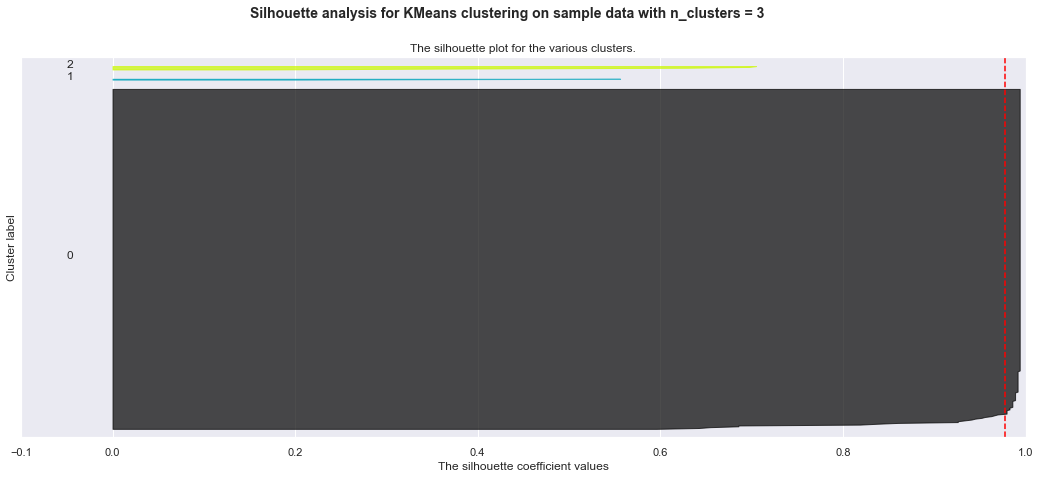

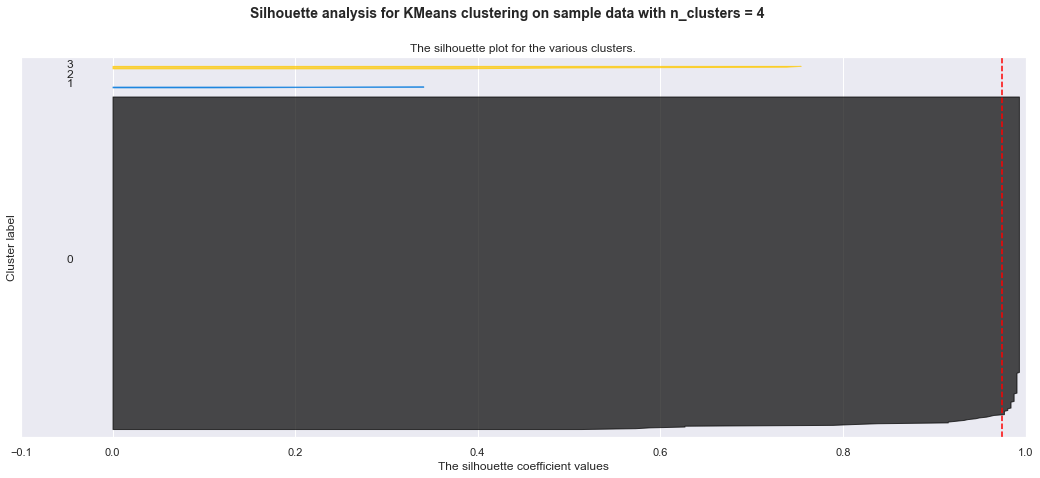

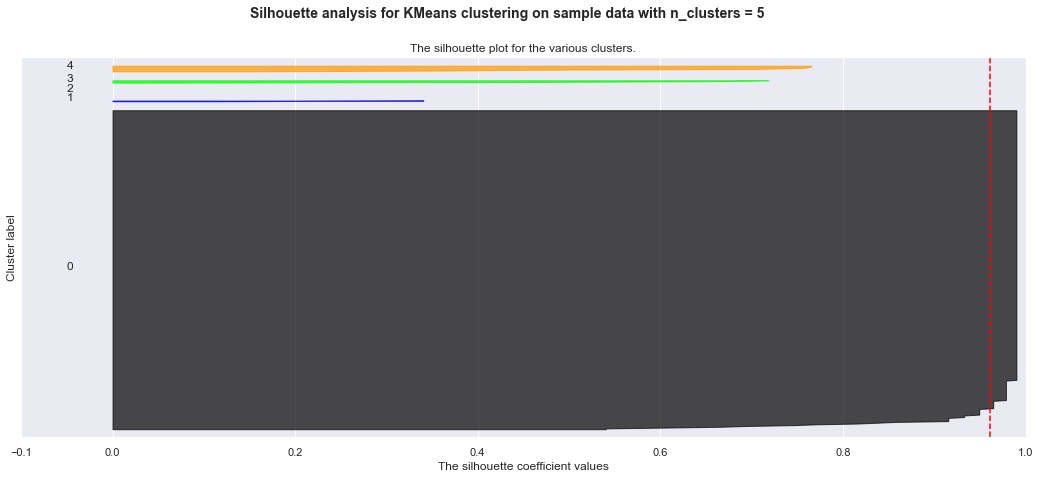

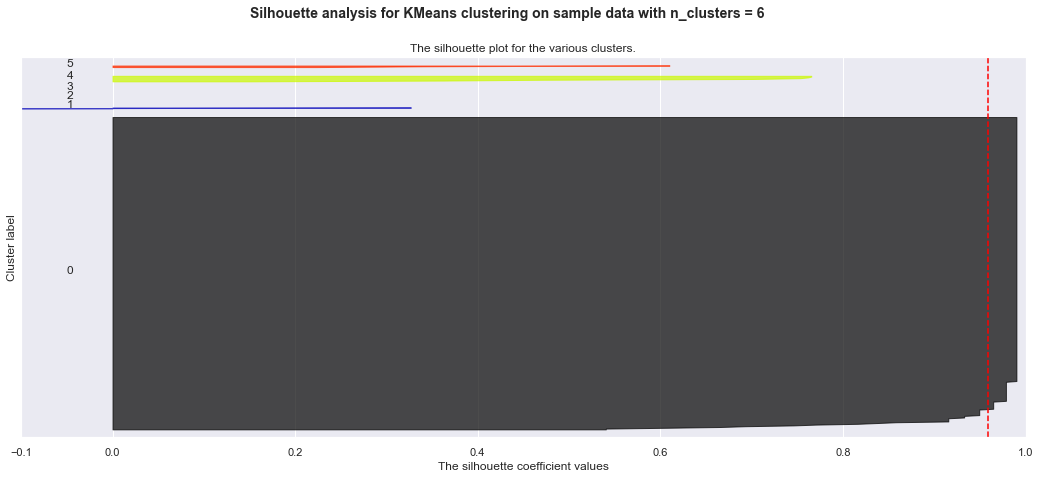

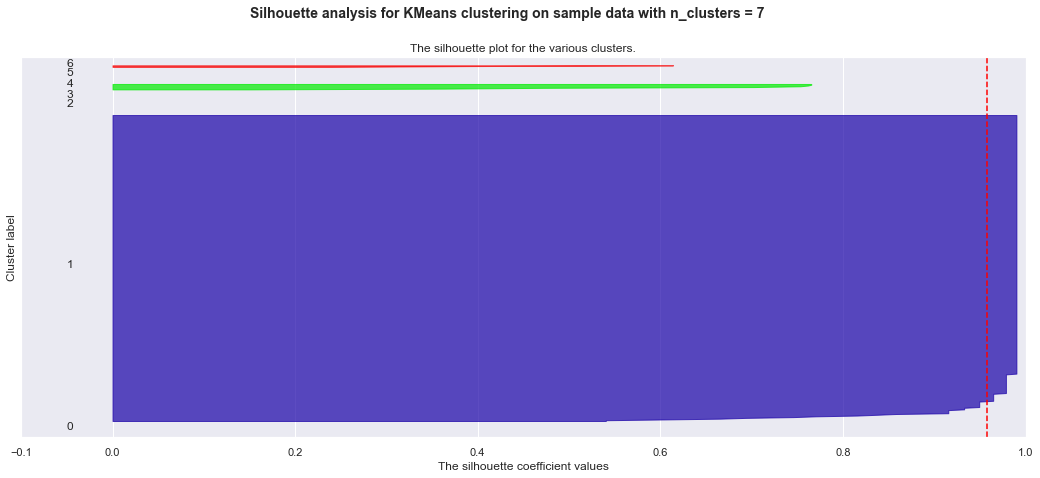

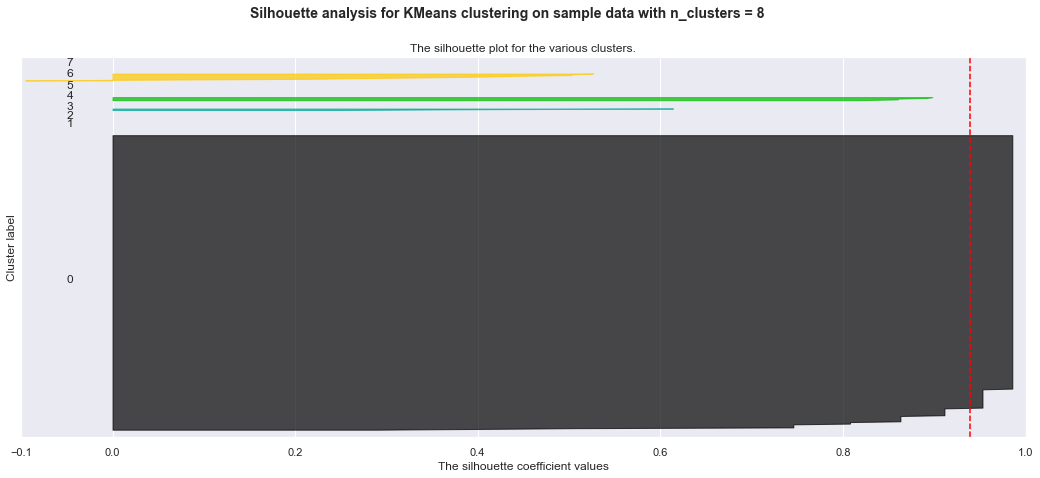

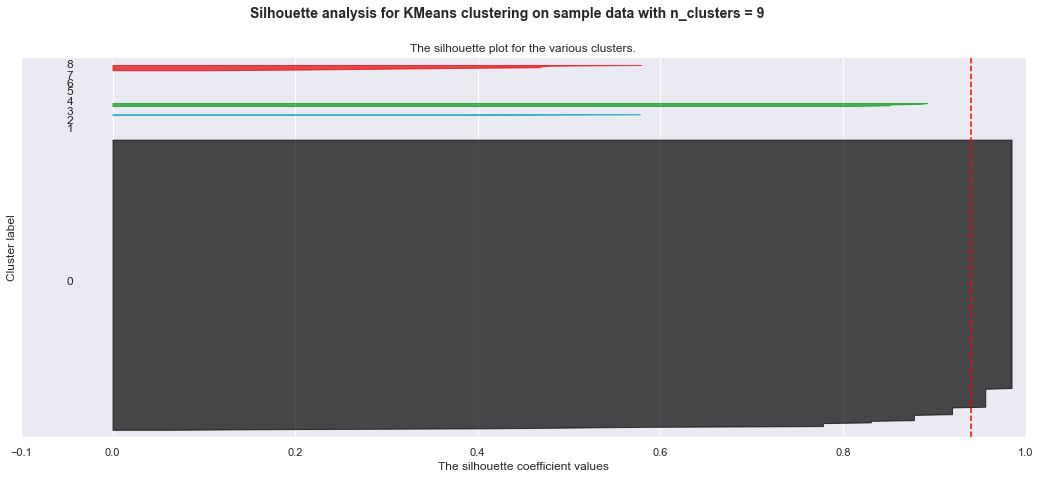

In [235]:
# calculate and plot silhouette scores for clusters
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

X = km_df

for n_clusters in range(3, 10):
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [295]:
# cluster students themselves based on rqa metrics
rqa_rows = []
for group_id, group_df in df_all_students.groupby(['id']):

    # forward/back fill NaN values to previous/next position
    group_df['LeftY'] = group_df['LeftY'].ffill()
    group_df['LeftY'] = group_df['LeftY'].bfill()
    group_df['RightY'] = group_df['RightY'].ffill()
    group_df['RightY'] = group_df['RightY'].bfill()

    x = group_df['LeftY']
    y = group_df['RightY']

    result = cross_rqa(x=x,y=y, id=group_id,plot=False,verbose=False)

    row = [
        group_id, 
        time_range, 
        result.recurrence_rate,
        result.determinism,
        result.average_diagonal_line,
        result.longest_diagonal_line,
        result.divergence,
        result.entropy_diagonal_lines,
        result.laminarity,
        result.trapping_time,
        result.longest_vertical_line,
        result.entropy_vertical_lines,
        result.average_white_vertical_line,
        result.longest_white_vertical_line,
        result.entropy_white_vertical_lines,
        result.ratio_determinism_recurrence_rate,
        result.ratio_laminarity_determinism
        ]

    rqa_rows.append(row)
    start = start + window

student_rqa_df = pd.DataFrame(rqa_rows,
    columns=[
        'id', 
        'time_window', 
        "recurrence_rate",
        "determinism",
        "average_diagonal_line",
        "longest_diagonal_line",
        "divergence",
        "entropy_diagonal_lines",
        "laminarity",
        "trapping_time",
        "longest_vertical_line",
        "entropy_vertical_lines",
        "average_white_vertical_line",
        "longest_white_vertical_line",
        "entropy_white_vertical_lines",
        "ratio_determinism_recurrence_rate",
        "ratio_laminarity_determinism"
        ])

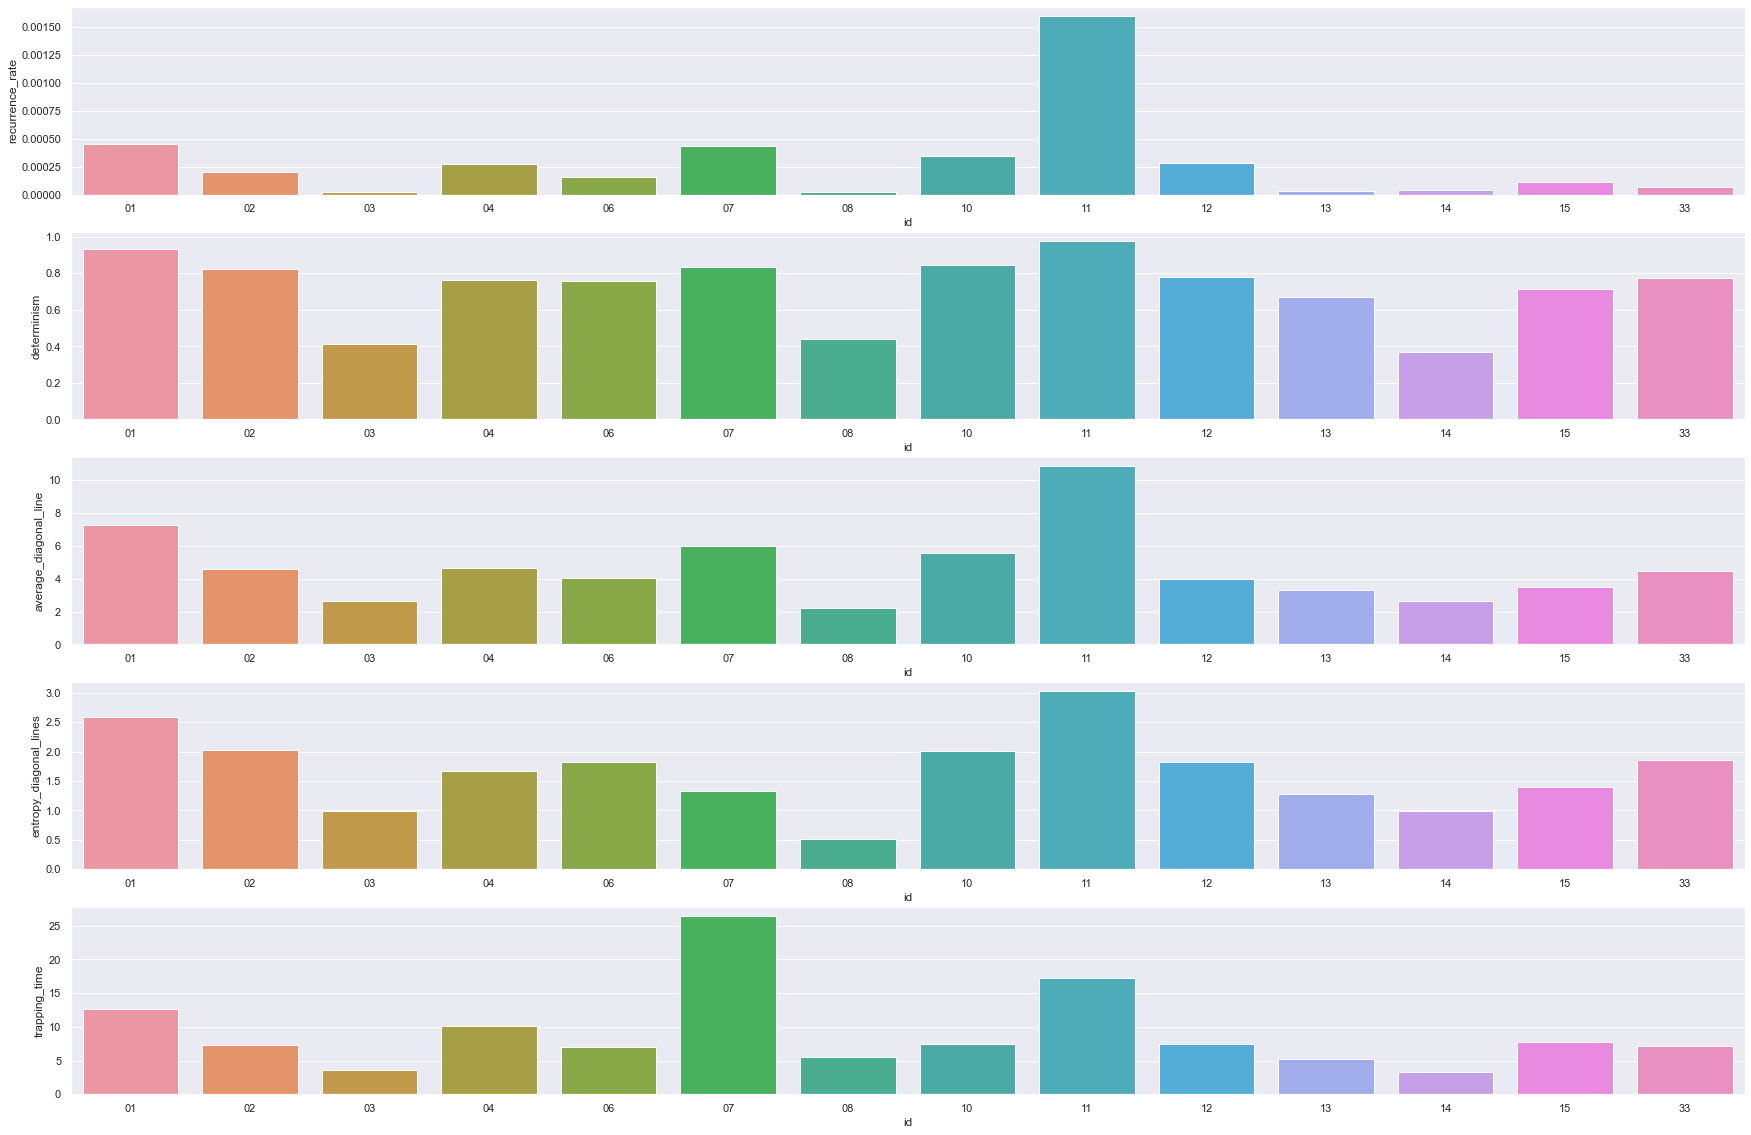

In [263]:
rqa_columns = ['recurrence_rate','determinism','average_diagonal_line','entropy_diagonal_lines','trapping_time']

fig, axs = plt.subplots(nrows=len(rqa_columns))

for i in range(len(rqa_columns)):
  sns.barplot(x='id', y=rqa_columns[i], data=rqa_df, ax=axs[i])

plt.savefig('rqa_metrics_across_students.png')


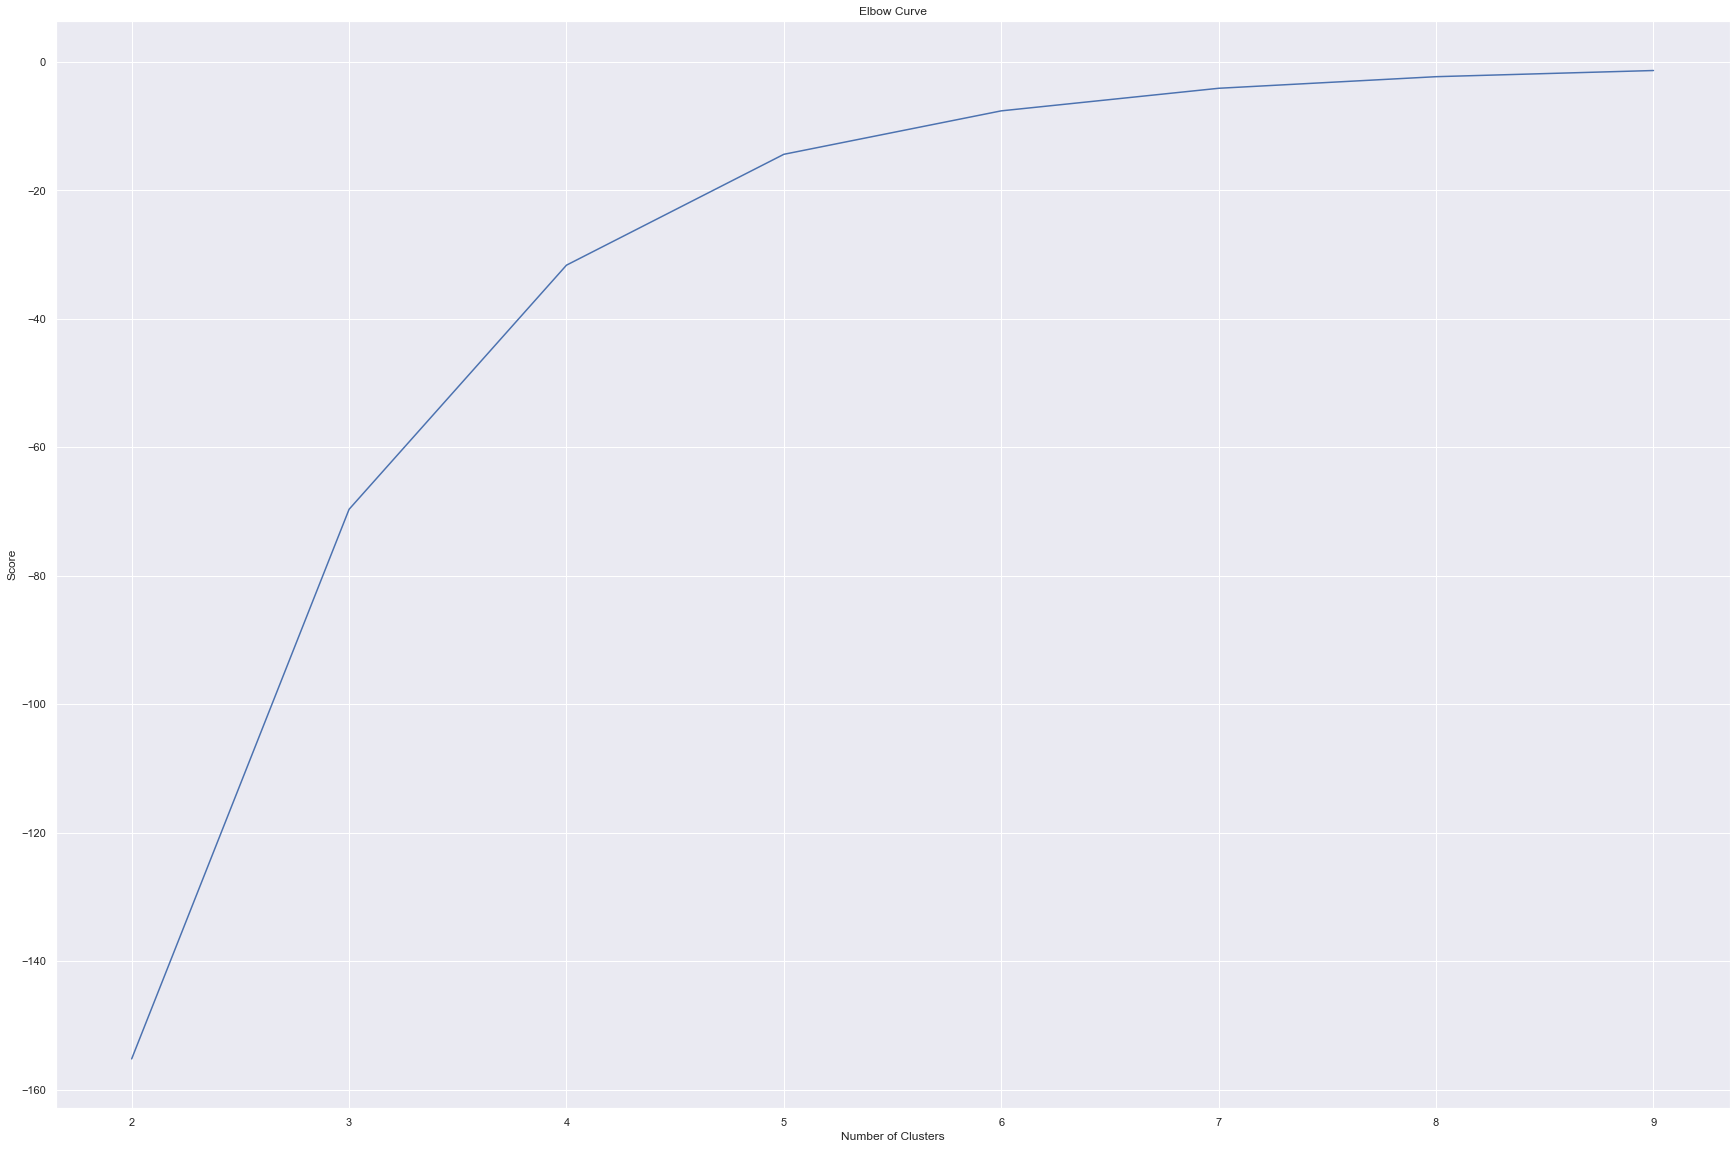

In [296]:
# find the best k val based on elbow method
student_km_df = pd.DataFrame(student_rqa_df[rqa_columns])

ks = range(2, 10)
kmeans = [KMeans(n_clusters=i) for i in ks]
score = [kmeans[i].fit(student_km_df).score(student_km_df) for i in range(len(kmeans))]

plt.plot(ks,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [297]:
# cluster data and visualize via TSNE dim reduction
# this produces df_viz.tsv, which is used in d3-scatterplot as an external tool
n_clusters = 5

km = KMeans(n_clusters=n_clusters)
y_km = km.fit_predict(student_km_df)
df_embed=TSNE(n_components=2, perplexity=50, method='barnes_hut', init='random', learning_rate='auto').fit_transform(student_km_df)

df_viz = pd.DataFrame(df_embed[:,:2],columns=["x","y"])

for c in rqa_columns:
  df_viz[c] = student_rqa_df[c]

# df_viz['Recurrence rate'] = student_rqa_df['recurrence_rate']
# df_viz['Determinism'] = student_rqa_df['determinism']
# df_viz['Mean line length'] = student_rqa_df['average_diagonal_line']
# df_viz['Normalized entropy'] = student_rqa_df['entropy_diagonal_lines']
# df_viz['Trapping time'] = student_rqa_df['trapping_time']
df_viz['Student ID'] = student_rqa_df['id']
df_viz['Clusters'] = km.labels_

filename = f"df_viz_k=%i_student.tsv" % n_clusters
df_viz.to_csv(f'../../mled-scatterplot/d3-scatterplot/%s' % (filename), sep='\t', index=False)

print(f'written to d3-scatterplot/%s' % (filename))

written to d3-scatterplot/df_viz_k=5_student.tsv
